### Feature Engineering 42x100

In [0]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import gc
import librosa

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive')

In [93]:
tracks = pd.read_csv('tracks.csv')
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [94]:
mfcc = pickle.load(open('mel-spec.pkl', 'rb'))
gc.collect()
mfcc[0]

array([[-65.062225, -47.759476, -44.176395, ..., -39.408173, -41.73693 ,
        -29.414968],
       [-65.40291 , -52.760864, -49.179825, ..., -16.405546, -16.314037,
        -17.623047],
       [-69.48193 , -56.67646 , -50.5069  , ..., -16.358839, -16.07241 ,
        -18.654762],
       ...,
       [-79.42308 , -59.74297 , -36.38287 , ..., -46.371128, -42.364655,
        -50.543457],
       [-80.      , -63.4197  , -41.733234, ..., -50.3838  , -46.90663 ,
        -58.020092],
       [-80.      , -73.82068 , -52.945995, ..., -63.188034, -56.469955,
        -67.65623 ]], dtype=float32)

In [95]:
mfcc[0].shape

(128, 646)

In [0]:
mfcc_df = pd.DataFrame(mfcc)
index_nan = np.argwhere(pd.isnull(mfcc))

In [97]:
mfcc_df = mfcc_df.dropna()
mfcc = mfcc_df.to_numpy().ravel()

max_dim = 0
for i in mfcc:
    if i.shape[1] > max_dim:
        max_dim = i.shape[1]
    else:
        pass
print(max_dim)

647


In [0]:
for i in range(len(mfcc)):
    mfcc[i] = np.append(mfcc[i], np.zeros((128, max_dim - mfcc[i].shape[1])), axis=1)
    mfcc[i] = mfcc[i][42:84, 0:100]
    mfcc[i] = librosa.util.normalize(mfcc[i])
    
index_nan = index_nan.ravel()


In [99]:
mfcc[4].shape

(42, 100)

In [0]:
del mfcc_df

In [101]:
gc.collect()

0

In [0]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [0]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

In [104]:
index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)

Int64Index([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,
            ...
            7981, 7982, 7983, 7984, 7985, 7986, 7987, 7994, 7995, 7996],
           dtype='int64', length=6397)
Int64Index([   5,   23,   28,   36,   58,   70,  117,  122,  126,  127,
            ...
            7854, 7855, 7856, 7857, 7858, 7859, 7860, 7869, 7871, 7928],
           dtype='int64', length=800)
Int64Index([   6,   39,   40,   41,   42,   43,   44,   55,   56,   64,
            ...
            7951, 7952, 7964, 7965, 7988, 7989, 7990, 7991, 7992, 7993],
           dtype='int64', length=800)


In [105]:
len(y_train) + len(y_val) + len(y_test)

7997

In [106]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

gc.collect()

0

In [107]:
mfcc = np.stack(mfcc.ravel()).reshape((-1, 42, 100))
gc.collect()

0

In [108]:
mfcc.shape

(7997, 42, 100)

In [109]:
mfcc = mfcc.reshape((-1, 42, 100, 1))
mfcc.shape

(7997, 42, 100, 1)

In [110]:
mfcc[0].shape

(42, 100, 1)

In [0]:
X_train = mfcc[index_train]
X_val = mfcc[index_val]
X_test = mfcc[index_test]

In [112]:
len(X_train)

6397

In [113]:
y_train.shape

(6397, 8)

In [114]:
X_train[0]

array([[[-0.89729261],
        [-0.87826993],
        [-0.84705981],
        ...,
        [-0.82893336],
        [-0.86851227],
        [-0.89546116]],

       [[-0.90864784],
        [-0.86458257],
        [-0.89280869],
        ...,
        [-0.71902976],
        [-0.74039966],
        [-0.86828396]],

       [[-0.91795203],
        [-0.80894961],
        [-0.73237008],
        ...,
        [-0.6260112 ],
        [-0.63366381],
        [-0.80096119]],

       ...,

       [[-0.94607476],
        [-0.85034679],
        [-0.81606109],
        ...,
        [-0.85882212],
        [-0.80319165],
        [-0.77697061]],

       [[-0.86075281],
        [-0.76593407],
        [-0.85887035],
        ...,
        [-0.74965191],
        [-0.6778962 ],
        [-0.65331452]],

       [[-0.86891926],
        [-0.77027269],
        [-0.87063011],
        ...,
        [-0.73497888],
        [-0.64266463],
        [-0.56037265]]])

### VGG progressive 42 x 100

In [26]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(42, 100, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9b9af51278> False
<keras.layers.convolutional.Conv2D object at 0x7f9b9af510f0> False
<keras.layers.convolutional.Conv2D object at 0x7f9be4c5f9b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b978cd128> False
<keras.layers.convolutional.Conv2D object at 0x7f9b978cd080> False
<keras.layers.convolutional.Conv2D object at 0x7f9b97807438> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b97807e10> False
<keras.layers.convolutional.Conv2D object at 0x7f9b97807dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f9b977f4b38> False
<keras.layers.convolutional.Conv2D object at 0x7f9b978026d8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b97802ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f9b97802fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f9b97812c88> False
<keras.layers.convolutional.Conv2D object at 0x7f9b977e6828> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b977e0d68>

In [116]:
X_train_RGB = X_train.reshape((-1, 42, 100))
X_train_RGB = np.repeat(X_train_RGB[..., np.newaxis], 3, -1)
X_train_RGB.shape

(6397, 42, 100, 3)

In [117]:
X_val_RGB = X_val.reshape((-1, 42, 100))
X_val_RGB = np.repeat(X_val_RGB[..., np.newaxis], 3, -1)
X_val_RGB.shape

(800, 42, 100, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_batchsize = 32
val_batchsize = 16
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=train_batchsize)
#val_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=val_batchsize, subset='validation')


In [0]:
model = keras.Sequential()

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2()))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

for cnn_block_layer in model.layers[0].layers:
    cnn_block_layer.trainable = False
  
model.layers[0].trainable = False
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

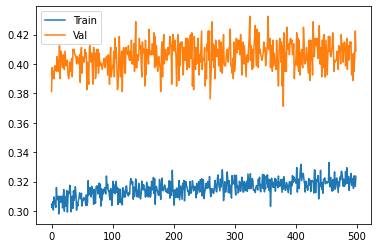

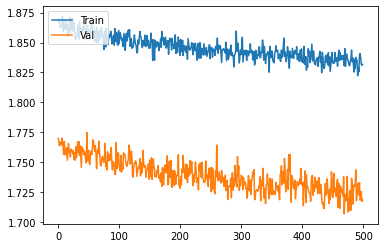

Train:
[1.7540934864237698, 0.37752071022987366]
Val:
[1.7266198301315308, 0.4325000047683716]


In [123]:
mcp_save = ModelCheckpoint('retrained-model-mel-spec-generator-progressive.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=500, validation_data=(X_val_RGB, y_val), callbacks=[mcp_save], verbose=0)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec-generator-progressive.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

### Feature Engineering 84x200

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import gc
import librosa

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive')

In [4]:
tracks = pd.read_csv('tracks.csv')
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mfcc = pickle.load(open('mel-spec.pkl', 'rb'))
gc.collect()
mfcc[0]

array([[-65.062225, -47.759476, -44.176395, ..., -39.408173, -41.73693 ,
        -29.414968],
       [-65.40291 , -52.760864, -49.179825, ..., -16.405546, -16.314037,
        -17.623047],
       [-69.48193 , -56.67646 , -50.5069  , ..., -16.358839, -16.07241 ,
        -18.654762],
       ...,
       [-79.42308 , -59.74297 , -36.38287 , ..., -46.371128, -42.364655,
        -50.543457],
       [-80.      , -63.4197  , -41.733234, ..., -50.3838  , -46.90663 ,
        -58.020092],
       [-80.      , -73.82068 , -52.945995, ..., -63.188034, -56.469955,
        -67.65623 ]], dtype=float32)

In [6]:
mfcc[0].shape

(128, 646)

In [0]:
mfcc_df = pd.DataFrame(mfcc)
index_nan = np.argwhere(pd.isnull(mfcc))

In [8]:
mfcc_df = mfcc_df.dropna()
mfcc = mfcc_df.to_numpy().ravel()

max_dim = 0
for i in mfcc:
    if i.shape[1] > max_dim:
        max_dim = i.shape[1]
    else:
        pass
print(max_dim)

647


In [0]:
for i in range(len(mfcc)):
    mfcc[i] = np.append(mfcc[i], np.zeros((128, max_dim - mfcc[i].shape[1])), axis=1)
    mfcc[i] = mfcc[i][21:105, 0:200]
    mfcc[i] = librosa.util.normalize(mfcc[i])
    
index_nan = index_nan.ravel()


In [10]:
mfcc[4].shape

(84, 200)

In [0]:
del mfcc_df

In [12]:
gc.collect()

0

In [0]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [0]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

In [15]:
index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)

Int64Index([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,
            ...
            7981, 7982, 7983, 7984, 7985, 7986, 7987, 7994, 7995, 7996],
           dtype='int64', length=6397)
Int64Index([   5,   23,   28,   36,   58,   70,  117,  122,  126,  127,
            ...
            7854, 7855, 7856, 7857, 7858, 7859, 7860, 7869, 7871, 7928],
           dtype='int64', length=800)
Int64Index([   6,   39,   40,   41,   42,   43,   44,   55,   56,   64,
            ...
            7951, 7952, 7964, 7965, 7988, 7989, 7990, 7991, 7992, 7993],
           dtype='int64', length=800)


In [16]:
len(y_train) + len(y_val) + len(y_test)

7997

In [17]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

gc.collect()

0

In [18]:
mfcc = np.stack(mfcc.ravel()).reshape((-1, 84, 200))
gc.collect()

0

In [19]:
mfcc.shape

(7997, 84, 200)

In [20]:
mfcc = mfcc.reshape((-1, 84, 200, 1))
mfcc.shape

(7997, 84, 200, 1)

In [21]:
mfcc[0].shape

(84, 200, 1)

In [0]:
X_train = mfcc[index_train]
X_val = mfcc[index_val]
X_test = mfcc[index_test]

In [23]:
len(X_train)

6397

In [24]:
y_train.shape

(6397, 8)

In [25]:
X_train[0]

array([[[-0.79008687],
        [-0.82937669],
        [-0.96926868],
        ...,
        [-0.55920659],
        [-0.42289533],
        [-0.91846662]],

       [[-0.74518974],
        [-0.79179873],
        [-0.89417721],
        ...,
        [-0.583906  ],
        [-0.28347741],
        [-0.67718205]],

       [[-0.7639578 ],
        [-0.68022845],
        [-0.71744701],
        ...,
        [-0.38204079],
        [-0.25213181],
        [-0.67643765]],

       ...,

       [[-0.96453814],
        [-0.95082735],
        [-0.78072869],
        ...,
        [-0.92255828],
        [-0.93400115],
        [-0.92797547]],

       [[-0.99957511],
        [-1.        ],
        [-0.78703802],
        ...,
        [-0.8770104 ],
        [-0.91102523],
        [-0.91478281]],

       [[-0.98499911],
        [-0.96413733],
        [-0.76823088],
        ...,
        [-0.78001824],
        [-0.84614052],
        [-0.96300048]]])

### VGG Progressive 84 x 200

In [27]:
X_train_RGB = X_train.reshape((-1, 84, 200))
X_train_RGB = np.repeat(X_train_RGB[..., np.newaxis], 3, -1)
X_train_RGB.shape

(6397, 84, 200, 3)

In [28]:
X_val_RGB = X_val.reshape((-1, 84, 200))
X_val_RGB = np.repeat(X_val_RGB[..., np.newaxis], 3, -1)
X_val_RGB.shape

(800, 84, 200, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_batchsize = 32
val_batchsize = 16
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=train_batchsize)
#val_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=val_batchsize, subset='validation')


In [0]:
model = keras.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(84, 200, 3), activation='relu', padding='same', data_format='channels_last'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# load the pretrained model
prior = load_model('retrained-model-mel-spec-generator-progressive.hdf5')

# add all but the first two layers of VGG16 to the new model
# strip the input layer out, this is now 96x96
# also strip out the first convolutional layer, this took the 48x48 input and convolved it but
# this is now the job of the three new layers.
for layer in prior.layers[0].layers[2:]:
    model.add(layer)

for layer in prior.layers[-4:]:
  layer.trainable=False

# re-add the feedforward layers on top
for layer in prior.layers[1:]:
  model.add(layer)

# the pretrained CNN layers are already marked non-trainable
# mark off the top layers as well


In [0]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

Epoch 1/50
200/199 [==============================] - 24s 118ms/step - loss: 2.2587 - categorical_accuracy: 0.1240 - val_loss: 2.1464 - val_categorical_accuracy: 0.1250
Epoch 2/50
200/199 [==============================] - 22s 112ms/step - loss: 2.2030 - categorical_accuracy: 0.1252 - val_loss: 2.1312 - val_categorical_accuracy: 0.1250
Epoch 3/50
200/199 [==============================] - 22s 112ms/step - loss: 2.1636 - categorical_accuracy: 0.1402 - val_loss: 2.0610 - val_categorical_accuracy: 0.1312
Epoch 4/50
200/199 [==============================] - 22s 111ms/step - loss: 2.1166 - categorical_accuracy: 0.1516 - val_loss: 1.9991 - val_categorical_accuracy: 0.1513
Epoch 5/50
200/199 [==============================] - 22s 111ms/step - loss: 2.0750 - categorical_accuracy: 0.1593 - val_loss: 1.9927 - val_categorical_accuracy: 0.1625
Epoch 6/50
200/199 [==============================] - 23s 114ms/step - loss: 2.0475 - categorical_accuracy: 0.1746 - val_loss: 1.9513 - val_categorical_acc

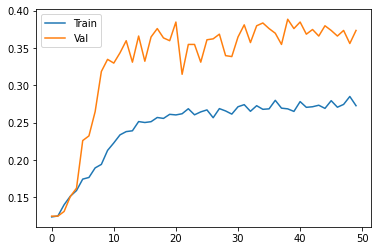

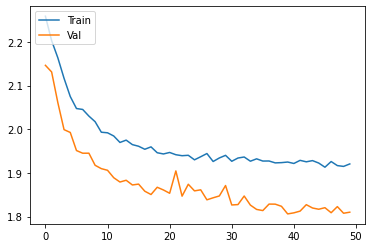

Train:
[1.8644373486223529, 0.3262466788291931]
Val:
[1.823633017539978, 0.38874998688697815]


In [32]:
mcp_save = ModelCheckpoint('retrained-model-mel-spec-generator-progressive-84.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=50, validation_data=(X_val_RGB, y_val), callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec-generator-progressive-84.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

In [36]:
X_test_RGB = X_test.reshape((-1, 84, 200))
X_test_RGB = np.repeat(X_test_RGB[..., np.newaxis], 3, -1)
X_test_RGB.shape

(800, 84, 200, 3)

In [37]:
from sklearn.metrics import classification_report

model = load_model('retrained-model-mel-spec-generator-progressive-84.hdf5')

y_pred = model.predict(X_test_RGB)
y_pred = np.argmax(y_pred, 1)

y_pred = le.inverse_transform(y_pred)
y_true_test = np.argmax(y_test, 1)
y_true_test = le.inverse_transform(y_true_test)

print(classification_report(y_true_test, y_pred))

               precision    recall  f1-score   support

   Electronic       0.32      0.33      0.33       100
 Experimental       0.26      0.12      0.16       100
         Folk       0.20      0.28      0.23       100
      Hip-Hop       0.52      0.68      0.59       100
 Instrumental       0.32      0.20      0.25       100
International       0.35      0.53      0.42       100
          Pop       0.50      0.01      0.02       100
         Rock       0.28      0.46      0.35       100

     accuracy                           0.33       800
    macro avg       0.34      0.33      0.29       800
 weighted avg       0.34      0.33      0.29       800



### Feature Engineering 128x300

In [0]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import gc
import librosa

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive')

In [0]:
tracks = pd.read_csv('tracks.csv')
tracks.columns = tracks.iloc[0]
tracks = tracks.drop([0, 1])
new_cols = tracks.columns.values
new_cols[0] = 'track_id'
tracks.columns = new_cols
tracks = tracks.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
mfcc = pickle.load(open('mel-spec.pkl', 'rb'))
gc.collect()
mfcc[0]

array([[-65.062225, -47.759476, -44.176395, ..., -39.408173, -41.73693 ,
        -29.414968],
       [-65.40291 , -52.760864, -49.179825, ..., -16.405546, -16.314037,
        -17.623047],
       [-69.48193 , -56.67646 , -50.5069  , ..., -16.358839, -16.07241 ,
        -18.654762],
       ...,
       [-79.42308 , -59.74297 , -36.38287 , ..., -46.371128, -42.364655,
        -50.543457],
       [-80.      , -63.4197  , -41.733234, ..., -50.3838  , -46.90663 ,
        -58.020092],
       [-80.      , -73.82068 , -52.945995, ..., -63.188034, -56.469955,
        -67.65623 ]], dtype=float32)

In [0]:
mfcc[0].shape

(128, 646)

In [0]:
mfcc_df = pd.DataFrame(mfcc)
index_nan = np.argwhere(pd.isnull(mfcc))

In [0]:
mfcc_df = mfcc_df.dropna()
mfcc = mfcc_df.to_numpy().ravel()

max_dim = 0
for i in mfcc:
    if i.shape[1] > max_dim:
        max_dim = i.shape[1]
    else:
        pass
print(max_dim)

647


In [0]:
for i in range(len(mfcc)):
    mfcc[i] = np.append(mfcc[i], np.zeros((128, max_dim - mfcc[i].shape[1])), axis=1)
    mfcc[i] = mfcc[i][:128, :300]
    mfcc[i] = librosa.util.normalize(mfcc[i])
    
index_nan = index_nan.ravel()


In [0]:
mfcc[4].shape

In [0]:
del mfcc_df

In [0]:
gc.collect()

In [0]:
tracks = tracks.loc[tracks['subset'] == 'small']
tracks = tracks.reset_index()
tracks = tracks.drop(index_nan)
tracks = tracks.reset_index()

In [0]:
y_train = tracks.loc[(tracks['split'] == 'training')]['genre_top']
y_val = tracks.loc[(tracks['split'] == 'validation')]['genre_top']
y_test = tracks.loc[(tracks['split'] == 'test')]['genre_top']

In [0]:
index_train = y_train.index
index_val = y_val.index
index_test = y_test.index
print(index_train)
print(index_val)
print(index_test)

In [0]:
len(y_train) + len(y_val) + len(y_test)

In [0]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype='int32')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype='int32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8, dtype='int32')

gc.collect()

In [0]:
mfcc = np.stack(mfcc.ravel()).reshape((-1, 128, 300))
gc.collect()

In [0]:
mfcc.shape

In [0]:
mfcc = mfcc.reshape((-1, 128, 300, 1))
mfcc.shape

In [0]:
mfcc[0].shape

In [0]:
X_train = mfcc[index_train]
X_val = mfcc[index_val]
X_test = mfcc[index_test]

In [0]:
len(X_train)

In [0]:
y_train.shape

In [0]:
X_train[0]

### VGG Progressive 128x300

In [0]:
X_train_RGB = X_train.reshape((-1, 128, 300))
X_train_RGB = np.repeat(X_train_RGB[..., np.newaxis], 3, -1)
X_train_RGB.shape

(6397, 42, 100, 3)

In [0]:
X_val_RGB = X_val.reshape((-1, 128, 300))
X_val_RGB = np.repeat(X_val_RGB[..., np.newaxis], 3, -1)
X_val_RGB.shape

(800, 42, 100, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_batchsize = 32
val_batchsize = 16
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=train_batchsize)
#val_generator = train_datagen.flow(X_train_RGB, y_train, batch_size=val_batchsize, subset='validation')


In [0]:
model = keras.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(84, 200, 3), activation='relu', padding='same', data_format='channels_last'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# load the pretrained model
prior = load_model('retrained-model-mel-spec-generator-progressive.hdf5')

# add all but the first two layers of VGG16 to the new model
# strip the input layer out, this is now 96x96
# also strip out the first convolutional layer, this took the 48x48 input and convolved it but
# this is now the job of the three new layers.
for layer in prior.layers[0].layers[2:]:
    model.add(layer)

for layer in prior.layers[-4:]:
  layer.trainable=False

# re-add the feedforward layers on top
for layer in prior.layers[1:]:
  model.add(layer)

# the pretrained CNN layers are already marked non-trainable
# mark off the top layers as well


In [0]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['categorical_accuracy'])

In [0]:
mcp_save = ModelCheckpoint('retrained-model-mel-spec-generator-progressive-84.hdf5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=0)
history = model.fit(train_generator, steps_per_epoch=len(X_train)/ train_batchsize, epochs=50, validation_data=(X_val_RGB, y_val), callbacks=[mcp_save])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = load_model('retrained-model-mel-spec-generator-progressive-84.hdf5')
print('Train:')
print(model.evaluate(X_train_RGB, y_train, verbose=2))
print('Val:')
print(model.evaluate(X_val_RGB, y_val, verbose=2))

ValueError: ignored

In [0]:
X_test_RGB = X_test.reshape((-1, 128, 400))
X_test_RGB = np.repeat(X_test_RGB[..., np.newaxis], 3, -1)
X_test_RGB.shape